In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

#Cuda 혹은 cpu를 사용하시오.
############Write Your Code Here############
device = 'cuda'
############################################


#Custom_Dataset을 정의하시오.(10점)
class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        #입력으로 들어온 X의 pixel값들을 0-1사이로 normalize하고 X의 shape을 (FB,C,H,W)로 변경하여 저장하여 self.X,self.y에 저장하시오.
        self.X = None
        self.y = None
        ############Write Your Code Here############
 
        self.X=np.transpose(X/255.0,(0,3,1,2)) ### 0-1 normalize, shape 변경
        self.y=y

        ############################################
        
    def __len__(self):
        #Custom_Dataset에 저장되어있는 총 data의 개수를 result에 저장하여 반환하시오.
        result = 0
        ############Write Your Code Here############
        
        result=len(self.X)
        
        ############################################
        return result
    
    def __getitem__(self, idx):
        #self.X, self.y 에서 idx에 맞는 data를 result_X,result_y에 저장하여 반환하시오.
        result_X,result_y = None,None
        ############Write Your Code Here############
        
        result_X=self.X[idx]
        result_y=self.y[idx]
        
        ############################################
        return result_X,result_y

    
#torch.nn을 사용하여 아래 함수들을 작성하시오. result는 nn.Layer중 하나이고 result를 반환함.(20점)
def batch_norm(dim,for_MLP=True):
    #for_MLP가 True일 시 MLP를 위한 BN Layer를 반환하고 False일 시 CNN을 위한 BN Layer를 반환함.
    ############Write Your Code Here############

    if for_MLP==True:
        result=nn.BatchNorm1d(dim)
    else:
        result=nn.BatchNorm2d(dim)    
    
    ############################################
    return result

def fc_layer(in_dim,out_dim):
    #Fully Connected Layer(Dense Layer)
    ############Write Your Code Here############
    
    result=nn.Linear(in_dim,out_dim)
    
    ############################################
    return result

def conv_layer(in_ch,out_ch,kernel_size, stride=1, padding=0):
    #Convolutional Layer for image
    ############Write Your Code Here############
    
    result=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
    
    ############################################
    return result

def relu():
    #ReLU function
    ############Write Your Code Here############
    
    result=nn.ReLU()
    
    ############################################
    return result

def flatten():
    #Flatten the data
    ############Write Your Code Here############
    
    result=nn.Flatten()
    
    ############################################
    return result


#skip_connection(bn -> relu -> conv -> bn -> relu -> conv)를 따르는 Res_block을 만드시오.
#change_res가 True인 res_block을 통과한 feature map은 resolution이 2배 작아지고 channel의 깊이는 2배로 증가함. ex) 32*8*8 -> 64*4*4
#위의 경우에는 skip_connection의 dimension은 1*1 conv로 맞춰줌.
#change_res가 False인 Res_block을 통과한 feature map은 resolution과 channel의 깊이는 그대로 유지됨. ex) 32*4*4 -> 32*4*4(20점)

class Res_block(nn.Module):
    def __init__(self, input_channel, change_res):
        super(Res_block,self).__init__()
        self.change_res = change_res 
        if change_res: ## res_block을 통과한것
            ############Write Your Code Here############
            self.conv1 = conv_layer(input_channel, input_channel*2, 3, stride = 2, padding=1)
            self.conv2 = conv_layer(input_channel*2, input_channel*2, 3, padding = 1)
            
            self.batch_n1 = batch_norm(input_channel,False)
            self.batch_n2 = batch_norm(input_channel*2,False)
            
            self.shortcut= conv_layer(input_channel, input_channel*2, 1, stride = 2)
            ############################################
        else:
            ############Write Your Code Here############
            self.conv1 = conv_layer(input_channel, input_channel, 3, padding = 1)
            self.conv2 = conv_layer(input_channel, input_channel, 3, padding = 1)

            self.batch_n1 = batch_norm(input_channel,False)
            self.batch_n2 = batch_norm(input_channel,False)
            ############################################
        ############Write Your Code Here############
        self.relu=relu()    
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        output=self.relu(self.batch_n1(X))
        output=self.conv1(output)
        output=self.relu(self.batch_n2(output))
        output=self.conv2(output)
        
        if self.change_res:
            shortcut=self.shortcut(X)
        else:
            shortcut=X
        
        X=output+shortcut
        ############################################
        return X

    
#Skip Connection을 이용하여 20개 이상의 layer를 가지고 테스트 셋에대하여 50% 이상의 성능을 주는 MLP를 만드시오.
#nn.ModuleList를 사용하면 많을 층의 layer를 쌓는데 용이함.(20점)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP,self).__init__()
        ############Write Your Code Here############
        
        self.fc1=fc_layer(input_dim,int(input_dim/3))
        self.fc_list1=nn.ModuleList([fc_layer(int(input_dim/3),int(input_dim/3)) for i in range(10)])
        self.fc2=fc_layer(int(input_dim/3),int(input_dim/6))
        self.fc_list2=nn.ModuleList([fc_layer(int(input_dim/6),int(input_dim/6)) for i in range(10)])
        self.fc3=fc_layer(int(input_dim/6),output_dim)        

        self.batch_norm1 = nn.ModuleList([batch_norm(int(input_dim/3)) for i in range(10)])
        self.batch_norm2 = nn.ModuleList([batch_norm(int(input_dim/6)) for i in range(10)])
                
        self.dropout_prob = 0.2
        
        self.relu=relu()
        self.flatten=flatten()         
        
        
        ############################################
    def forward(self,X):
        ############Write Your Code Here############

        X=self.flatten(X)
        
        X=self.fc1(X)
         
        for i in range(10):
            X = X + self.fc_list1[i](self.relu(self.batch_norm1[i](X)))        
            X=nn.functional.dropout(X, training = self.training, p = self.dropout_prob) # dropout 적용
        
        X=self.fc2(X)
    
        for i in range(10):
            X = X + self.fc_list2[i](self.relu(self.batch_norm2[i](X))) 
            X=nn.functional.dropout(X, training = self.training, p = self.dropout_prob) # dropout 적용
        
        X=self.fc3(X)    
        
        ############################################
        return X
        
#Res_Block을 사용하여 테스트 셋에대한 70% 이상의 성능을 주는 CNN 모델을 만드시오.
#flatten전에 nn.AdaptiveAvgPool2d를 사용하면 dimension맞추기가 쉬움.(20점)
class CNN(nn.Module):
    def __init__(self, input_channel, class_number, block_number):
        super(CNN,self).__init__()
        ############Write Your Code Here############
        self.conv1 = conv_layer(input_channel, 64, 3)
        divide_layer =[int(block_number/4)+1 if i<2 else int(block_number/4) for i in range(4)]

        sub_layers=[]
        for idx,value in enumerate(divide_layer):
            if idx==0:
                #sub_layers=sub_layers+[Res_block(2**(6+idx),False) for _ in range(value)]
                sub_layers.extend([Res_block(2**(6+idx),False) for _ in range(value)])
            elif value>0:
                #sub_layers=sub_layers+[Res_block(2**(6+idx-1),True)] + [Res_block(2**(6+idx),False) for _ in range(1,value)]
                sub_layers.extend([Res_block(2**(6+idx-1),True)])
                sub_layers.exten
        self.layer_list=nn.Sequential(*sub_layers)
        
        self.fc1=fc_layer(512,256)
        self.fc2=fc_layer(256,class_number)
        
        self.flatten=flatten()
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
        self.relu=relu()
             
        
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        X=self.conv1(X)
        X=self.layer_list(X)
        X=self.flatten(self.avg_pool(X))
        X=self.relu(self.fc1(X))
        X=self.fc2(X)
        
        ############################################
        return X

#loader에 있는 모든 data들에 대한 정확도를 구하여 accuracy에 저장하여 accuracy를 return하는 함수를 구현하시오.(10점)
def evaluate(model, loader):
    model.eval()
    accuracy = 0
    total_example = 0
    correct_example = 0
    for data in loader:
        x,y = data
        x = torch.tensor(x, device = device)
        y = torch.tensor(y, device = device)
        ############Write Your Code Here############
        
        with torch.no_grad(): 
            output=model(x.float())
            prediction=output.max(1,keepdim=True)[1]
            correct_example+=prediction.eq(y.view_as(prediction)).sum().item()
            
        total_example=len(loader.dataset)
        
        ############################################
    ############Write Your Code Here############
    
    accuracy=(100*correct_example)/total_example
    
    ############################################
    model.train()
    return accuracy

#epoch마다 train_loader에 있는 batch들을 사용하여 모델을 학습하고
#epoch의 마지막 iteration에서는 모델의 validation accuracy를 확인하여 제일 높은 val. acc.를 가진 model을 best_model에 저장하고
#val_acc에는 매 epoch마다 구해진 validation accuracy를 저장하시오.
#running_loss에는 각각의 epoch에서 모든 batch의 loss를 다 더하여 저장하시오.
#모든 epoch의 validation accuracy를 val_acc에 저장하여 best_model과 val_acc를 return하는 함수를 구현하시오.(10점)
def train(model, epoches, train_loader, val_loader, optimizer, criteria):
    best_score = 0
    best_model = None
    batch_len = len(train_loader)
    val_acc = []
    for epoch in range(epoches):
        running_loss = 0
        for i,data in enumerate(train_loader):
            x,y = data
            x = torch.tensor(x, device = device)
            y = torch.tensor(y, device = device)
            ############Write Your Code Here############
            
            model.train() 
            optimizer.zero_grad() 
            output=model(x.float())
            loss=criteria(output,y.long())
            loss.backward() 
            optimizer.step()
            
            # loss
            running_loss+=loss.item()             
            
            ############################################
            
            #epoch의 마지막 iteration
            if i % batch_len == batch_len-1:
                print(f'{epoch+1}th iteration loss :',running_loss/batch_len)
                running_loss = 0
                ############Write Your Code Here############

                val_score = evaluate(model,val_loader)
                val_acc.append(val_score)
                if val_score>=best_score:
                    best_score=val_score 
                    best_model=deepcopy(model)
                
                ############################################
    return best_model, val_acc

Files already downloaded and verified
Files already downloaded and verified


/home/jihwan39/torchjh/lib/python3.6/site-packages/ipykernel_launcher.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jihwan39/torchjh/lib/python3.6/site-packages/ipykernel_launcher.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1th iteration loss : 4.694874927496454


/home/jihwan39/torchjh/lib/python3.6/site-packages/ipykernel_launcher.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jihwan39/torchjh/lib/python3.6/site-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2th iteration loss : 4.127918342116532
3th iteration loss : 3.8601530585319375
4th iteration loss : 3.6465416121634706
5th iteration loss : 3.498395774015196
6th iteration loss : 3.366322026890554
7th iteration loss : 3.256765458234556
8th iteration loss : 3.137994871018039
9th iteration loss : 3.0550041608749683
10th iteration loss : 2.978939291777884
11th iteration loss : 2.9146219742525914
12th iteration loss : 2.8238054293735773
13th iteration loss : 2.7753875726347514
14th iteration loss : 2.7070118606470195
15th iteration loss : 2.65732586763467
16th iteration loss : 2.6015843722471006
17th iteration loss : 2.556114761692703
18th iteration loss : 2.494835792833073
19th iteration loss : 2.440817384962823
20th iteration loss : 2.4012438932042213
21th iteration loss : 2.3729064062142826
22th iteration loss : 2.3096650254194904
23th iteration loss : 2.263796047040611
24th iteration loss : 2.2205899604566537
25th iteration loss : 2.189963926175597
26th iteration loss : 2.1687198900113

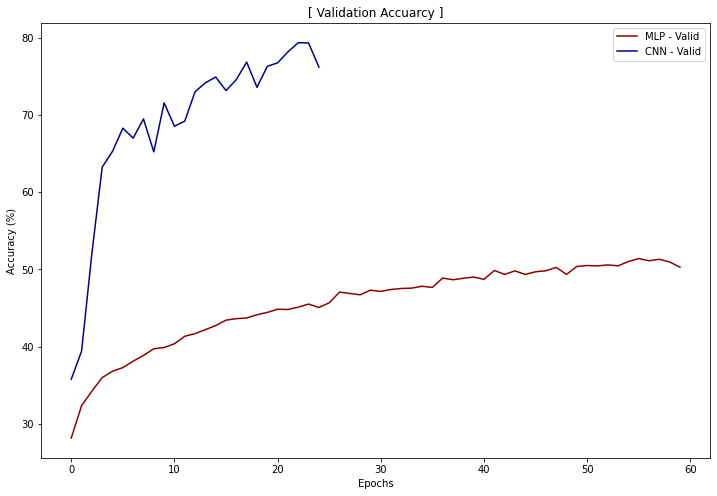

In [2]:
#(50점)
#Read the data
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True)

X_train, Y_train = trainset.data, np.array(trainset.targets)
X_test, Y_test = testset.data, np.array(testset.targets)


#앞서 정의한 Custom_Dataset과 DataLoader를 사용하여 train_loader,val_loader,test_loader를 정의하시오.
#Batch_size는 본인의 컴퓨터 사향에 맞게 변경하면 됨. Validation Set으로 Train Set의 20%를 사용함.
#Preprocessing
train_loader = None
val_loader = None
test_loader = None
batch_size = 1
############Write Your Code Here############

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

batch_size = 256

train_loader = DataLoader(Custom_Dataset(X_train,Y_train), batch_size = batch_size)
val_loader = DataLoader(Custom_Dataset(X_val,Y_val), batch_size = batch_size)
test_loader = DataLoader(Custom_Dataset(X_test,Y_test), batch_size = batch_size)


############################################


#앞서 정의한 MLP,CNN을 사용하여 mlp_model,cnn_model을 정의하시오.
#Define the model
mlp_model = None
cnn_model = None
############Write Your Code Here############

input_dim=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
output_dim=len(np.unique(Y_train))
mlp_model=MLP(input_dim,output_dim)
cnn_model=CNN(X_train.shape[3],output_dim,30) #ResNet 30

############################################
mlp_model.to(device)
cnn_model.to(device)


#앞서 정의한 train함수를 사용하여 best_mlp, mpl_val_acc, best_cnn, cnn_val_acc를 구하시오.
#Train the model
best_mlp = None
mlp_val_acc = None
best_cnn = None
cnn_val_acc = None
############Write Your Code Here############

mlp_optimizer=torch.optim.Adam(mlp_model.parameters(),lr=0.00001)
cnn_optimizer=torch.optim.Adam(cnn_model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
best_mlp,mlp_val_acc=train(mlp_model,60,train_loader, val_loader,mlp_optimizer,criterion)
print('===============================CNN Start====================================')
best_cnn,cnn_val_acc=train(cnn_model,25,train_loader, val_loader,cnn_optimizer,criterion)
print('===============================Train End====================================')


############################################


#앞서 정의한 evaluate함수와 best_model들을 사용하여 mlp_acc, cnn_acc를 구하시오.
#Test Accuracy
mlp_acc = None  
cnn_acc = None 
############Write Your Code Here############

mlp_acc=evaluate(mlp_model,test_loader)
cnn_acc=evaluate(cnn_model,test_loader)

############################################
print('MLP accuracy:',mlp_acc)
print('CNN accuracy:',cnn_acc)


#앞서 구한 val_acc들을 사용하여 이해 가능한 그래프를 그리시오.
#Validation Accuracy Plot
############Write Your Code Here############

plt.rcParams["figure.figsize"] = (12,8)
plt.title('[ Validation Accuarcy ]')
plt.plot(np.arange(len(mlp_val_acc)),mlp_val_acc,label='valid',color='darkred')
plt.plot(np.arange(len(cnn_val_acc)),cnn_val_acc,label='valid',color='darkblue')
plt.legend(['MLP - Valid','CNN - Valid'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.show()

############################################

In [1]:
a=[1,2,3]
b=[4,5,6]
a+b

[1, 2, 3, 4, 5, 6]

In [3]:
a.extend([4])

In [4]:
a

[1, 2, 3, 4]